In [1]:
import socket
import datetime
from datetime import datetime, timedelta
import re
import pandas as pd
import numpy as np
import time

In [3]:
base_dir = 'C:\\Users\\zhangzhida\\Desktop\\EyeGazePipeline\\data\\'

In [13]:
df = pd.read_csv(base_dir + 'gaze_data.csv')

In [14]:
df.shape

(210, 13)

In [15]:
df

,Date,Time,FPOGID,FPOGD,FPOGX,FPOGY,LPOGX,LPOGY,RPOGX,RPOGY,CX,CY,timestamp
0,2019-11-06,16:40:26,1748,0.42773,0.07393,0.68164,0.02850,0.67527,0.12486,0.71146,0.80260,0.05000,1.573098e+09
1,2019-11-06,16:40:26,1748,0.57568,0.07287,0.68551,0.05937,0.66690,0.07042,0.75098,0.80260,0.05000,1.573098e+09
2,2019-11-06,16:40:26,1748,0.59229,0.07274,0.68628,0.06180,0.67094,0.07390,0.75673,0.80260,0.05000,1.573098e+09
3,2019-11-06,16:40:26,1748,0.60889,0.07175,0.68691,-0.00172,0.69775,0.07202,0.72272,0.80260,0.05000,1.573098e+09
4,2019-11-06,16:40:26,1748,0.62549,0.07161,0.68881,0.01136,0.67850,0.12152,0.84320,0.80260,0.05000,1.573098e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2019-11-06,16:40:31,1762,0.06689,0.36180,0.80686,0.37435,0.74347,0.38668,0.81780,0.83229,0.04537,1.573098e+09
206,2019-11-06,16:40:31,1762,0.08301,0.36466,0.80078,0.37429,0.73270,0.38369,0.80803,0.83229,0.04537,1.573098e+09
207,2019-11-06,16:40:31,1762,0.09961,0.34030,0.79508,0.11524,0.61541,0.27296,0.90641,0.83229,0.04537,1.573098e+09
208,2019-11-06,16:40:31,1762,0.11572,0.33779,0.76983,0.28140,0.43416,0.35913,0.75199,0.83229,0.04537,1.573098e+09


In [3]:


# from PIL import ImageGrab
# import pyautogui
# from mss import mss
# import cv2 

# Host machine IP
HOST = '127.0.0.1'
# Gazepoint Port
PORT = 4242 
ADDRESS = (HOST, PORT)
InputBufferSize = 4096

#Get the gaze tracking screen position and size or set the screen on which the gaze tracking is to be performed.
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(ADDRESS)

s.send(str.encode('<GET ID="SCREEN_SIZE" />\r\n'))
s.send(str.encode('<SET ID="ENABLE_SEND_DATA" STATE="1" />\r\n'))
rxdat = s.recv(InputBufferSize)
string = bytes.decode(rxdat)
ID, X, Y, WIDTH, HEIGHT = re.findall(r'"(.*?)"', string)
if ID =='SCREEN_SIZE':
    print('captured screen dimensions')
else:
    print('did not captured screen dimensions')
s.close()
time.sleep(0.25)

# configure data server
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(ADDRESS)
s.send(str.encode('<SET ID="ENABLE_SEND_COUNTER" STATE="1" />\r\n'))
s.send(str.encode('<SET ID="ENABLE_SEND_CURSOR" STATE="1" />\r\n'))
s.send(str.encode('<SET ID="ENABLE_SEND_POG_FIX" STATE="1" />\r\n'))
s.send(str.encode('<SET ID="ENABLE_SEND_POG_LEFT" STATE="1" />\r\n'))
s.send(str.encode('<SET ID="ENABLE_SEND_POG_RIGHT" STATE="1" />\r\n'))
#s.send(str.encode('<SET ID="ENABLE_SEND_TIME" STATE="1" />\r\n'))

#start data server sending data
s.send(str.encode('<SET ID="ENABLE_SEND_DATA" STATE="1" />\r\n'))

time.sleep(0.25)

                
    
ii = -1
tot_sec= 30 # 120
print('run tracking for',tot_sec,'seconds')
t_end = datetime.now() + timedelta(seconds=tot_sec)
df = pd.DataFrame(columns=['Date','Time','FPOGID','FPOGD', 'FPOGX', 'FPOGY','LPOGX','LPOGY','RPOGX','RPOGY','CX', 'CY', 'timestamp'])

rate=30
print('smoothing rate', rate, 'per second')


while datetime.now() < t_end:
    
    timestamp0 = time.time()
    rxdat = s.recv(InputBufferSize)
    string = bytes.decode(rxdat)
    
    ts = datetime.now().strftime('%Y-%m-%d %H:%M:%S:%f')
    timestamp = time.time()
    print(timestamp - timestamp0)
    
    # print(string)
    # only parse if a data REC response was recieved (ignore CALib etc)
    if len(rxdat) > 0 and "<REC" in string:
        string = [i for i in string.split('<') if i[:3] == 'REC'][0]
        
        re.findall(r'"(.*?)"', string)
        CNT,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPOGX,LPOGY,LPOGV,RPOGX,RPOGY,RPOGV,CX,CY,CS = re.findall(r'"(.*?)"', string)
        
        if FPOGV == "1":
            FPOGV=1.0
        else:
            FPOGV = np.nan
            
        if LPOGV == "1":
            LPOGV = 1.0
        else:
            LPOGV = np.nan
            
        if RPOGV == "1":
            RPOGV = 1.0
        else:
            RPOGV = np.nan
             
        dt = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        ii += 1
        df.loc[ii] = dt.split(' ')[0], dt.split(' ')[1], int(FPOGID), np.float(FPOGD)*FPOGV, \
                            np.float(FPOGX)*FPOGV, np.float(FPOGY)*FPOGV, \
                            np.float(LPOGX)*LPOGV, np.float(LPOGY)*LPOGV,\
                            np.float(RPOGX)*RPOGV, np.float(RPOGY)*RPOGV, \
                            np.float(CX), np.float(CY), timestamp
        
        
s.close()
df = df.fillna(method='ffill')
df.to_csv('data_try.csv', mode='a')

print('Done!')

captured screen dimensions
run tracking for 120 seconds
smoothing rate 30 per second
0.0
0.00690150260925293
0.0
0.01590585708618164
0.03134608268737793
0.01582789421081543
0.015599966049194336
0.015604019165039062
0.02232670783996582
0.0
0.015498161315917969
0.015552520751953125
0.03098154067993164
0.008176088333129883
0.007022857666015625
0.011228561401367188
0.01193690299987793
0.020264387130737305
0.01563858985900879
0.015605449676513672
0.029767751693725586
0.0
0.031103849411010742
0.0
0.01538538932800293
0.013973474502563477
0.013998985290527344
0.008976459503173828
0.01253199577331543
0.02342700958251953
0.015820026397705078
0.015625476837158203
0.03027939796447754
0.0
0.01562809944152832
0.015611648559570312
0.007514238357543945
0.013037919998168945
0.009695053100585938
0.010713815689086914
0.01796579360961914
0.009484052658081055
0.007048845291137695
0.028550386428833008
0.0
0.0297849178314209
0.015615701675415039
0.015620708465576172
0.007975339889526367
0.010015726089477539


0.005983114242553711
0.00797724723815918
0.008972406387329102
0.012918472290039062
0.005980491638183594
0.0069773197174072266
0.0109710693359375
0.012966394424438477
0.009961605072021484
0.007982015609741211
0.01296544075012207
0.011956214904785156
0.0059814453125
0.005984067916870117
0.01496124267578125
0.0069806575775146484
0.009996652603149414
0.011269807815551758
0.012763738632202148
0.013935327529907227
0.010186433792114258
0.012346506118774414
0.011417627334594727
0.012388944625854492
0.010752677917480469
0.013585567474365234
0.011007070541381836
0.012496232986450195
0.019896745681762695
0.027384042739868164
0.0
0.004235029220581055
0.0059506893157958984
0.009946823120117188
0.01294565200805664
0.0029900074005126953
0.01396322250366211
0.00798940658569336
0.006983041763305664
0.007977485656738281
0.012967109680175781
0.009973287582397461
0.007982254028320312
0.008977413177490234
0.006006479263305664
0.019947052001953125
0.0009961128234863281
0.0039937496185302734
0.00998067855834

0.03066873550415039
0.0
0.012327432632446289
0.007061481475830078
0.024862051010131836
0.026927471160888672
0.0
0.015424966812133789
0.015641212463378906
0.015799760818481445
0.015216827392578125
0.01550436019897461
0.022675037384033203
0.0
0.008534431457519531
0.006270170211791992
0.010509967803955078
0.01562190055847168
0.028202295303344727
0.015617609024047852
0.015358924865722656
0.009844779968261719
0.003982067108154297
0.005982160568237305
0.012966632843017578
0.009196996688842773
0.009180545806884766
0.007974624633789062
0.00894474983215332
0.010088920593261719
0.012270927429199219
0.016911983489990234
0.01574230194091797
0.015609264373779297
0.015729188919067383
0.015541553497314453
0.015805959701538086
0.01611495018005371
0.015128374099731445
0.012804508209228516
0.0059812068939208984
0.019802331924438477
0.02744436264038086
0.0
0.01596975326538086
0.015586376190185547
0.015752792358398438
0.015530586242675781
0.015200138092041016
0.023139238357543945
0.015645503997802734
0.00

0.015874385833740234
0.008656024932861328
0.007083892822265625
0.010870695114135742
0.010108470916748047
0.026368141174316406
0.015843629837036133
0.015606403350830078
0.015994787216186523
0.01557469367980957
0.015638351440429688
0.01569652557373047
0.008415460586547852
0.0030150413513183594
0.00977015495300293
0.008373260498046875
0.011244773864746094
0.015622615814208984
0.015918493270874023
0.03115534782409668
0.01544499397277832
0.015594720840454102
0.01564645767211914
0.022471904754638672
0.0
0.0
0.00961923599243164
0.011123895645141602
0.015941381454467773
0.015506744384765625
0.015833616256713867
0.015965700149536133
0.015266180038452148
0.015903711318969727
0.015504837036132812
0.015573501586914062
0.02173137664794922
0.011001348495483398
0.005538225173950195
0.015166282653808594
0.010047197341918945
0.019281625747680664
0.015626907348632812
0.016191482543945312
0.015622377395629883
0.015628337860107422
0.015606164932250977
0.015522003173828125
0.02193427085876465
0.0
0.0109703

0.01371455192565918
0.010355949401855469
0.008075714111328125
0.0330052375793457
0.0
0.015574455261230469
0.03129124641418457
0.0
0.015497207641601562
0.015309810638427734
0.022356033325195312
0.015910625457763672
0.012611865997314453
0.009912252426147461
0.0060651302337646484
0.039868831634521484
0.0
0.01558828353881836
0.015347719192504883
0.015904664993286133
0.015427589416503906
0.015409708023071289
0.022470951080322266
0.01562047004699707
0.00838923454284668
0.008976936340332031
0.011967182159423828
0.01009058952331543
0.007979393005371094
0.015633344650268555
0.01566934585571289
0.015688419342041016
0.015717506408691406
0.015398740768432617
0.027768850326538086
0.015616893768310547
0.0
0.00971841812133789
0.0063495635986328125
0.01674199104309082
0.023744583129882812
0.01562190055847168
0.01608586311340332
0.015351295471191406
0.015682697296142578
0.015290260314941406
0.022713661193847656
0.01534271240234375
0.007280826568603516
0.005280256271362305
0.012005329132080078
0.0104742

0.015520334243774414
0.0
0.009622573852539062
0.009420156478881836
0.0357823371887207
0.0
0.016162395477294922
0.01564502716064453
0.031078100204467773
0.0
0.01522374153137207
0.023197650909423828
0.009780406951904297
0.0069599151611328125
0.008562326431274414
0.009978294372558594
0.015645980834960938
0.029685258865356445
0.01616215705871582
0.015611410140991211
0.015619516372680664
0.015568256378173828
0.01539468765258789
0.021961688995361328
0.00810384750366211
0.003305196762084961
0.008168935775756836
0.009386062622070312
0.016178131103515625
0.031130313873291016
0.0
0.015431642532348633
0.015312433242797852
0.03124260902404785
0.015944480895996094
0.02247762680053711
0.0
0.000997781753540039
0.009098052978515625
0.009269952774047852
0.01605391502380371
0.01605510711669922
0.016198158264160156
0.015596151351928711
0.015502214431762695
0.015659332275390625
0.030777454376220703
0.02272319793701172
0.0
0.0009953975677490234
0.005216360092163086
0.009806394577026367
0.01844620704650879


0.03104090690612793
0.007941484451293945
0.005983829498291016
0.010779142379760742
0.007635831832885742
0.023273468017578125
0.015924453735351562
0.01588129997253418
0.01562809944152832
0.015581607818603516
0.026714086532592773
0.0
0.01537013053894043
0.01316070556640625
0.0129852294921875
0.010942459106445312
0.03032207489013672
0.0
0.015477180480957031
0.015850543975830078
0.031252145767211914
0.0
0.022127628326416016
0.016193389892578125
0.01562666893005371
0.0
0.008834600448608398
0.009806394577026367
0.011817693710327148
0.024738073348999023
0.01562976837158203
0.015532493591308594
0.015705347061157227
0.01556086540222168
0.0030171871185302734
0.0088958740234375
0.013455867767333984
0.008974552154541016
0.012311220169067383
0.011919021606445312
0.015874385833740234
0.0256502628326416
0.015656709671020508
0.01613783836364746
0.015389204025268555
0.01586174964904785
0.015451908111572266
0.022371530532836914
0.0
0.01517939567565918
0.01845097541809082
0.010934114456176758
0.010341405

0.015648841857910156
0.0
0.010200977325439453
0.010936498641967773
0.025621891021728516
0.015572547912597656
0.015610694885253906
0.016187429428100586
0.015623331069946289
0.01563239097595215
0.015625953674316406
0.015621185302734375
0.0
0.0049588680267333984
0.013348579406738281
0.006262063980102539
0.010974884033203125
0.010414600372314453
0.008952140808105469
0.021598339080810547
0.015620946884155273
0.01582169532775879
0.022668123245239258
0.0
0.0
0.007218599319458008
0.0159609317779541
0.01533961296081543
0.03726077079772949
0.0
0.030812740325927734
0.0
0.01551961898803711
0.015615701675415039
0.038611650466918945
0.0010249614715576172
0.010104894638061523
0.00914764404296875
0.012328624725341797
0.016185760498046875
0.01619553565979004
0.03080916404724121
0.0
0.015752792358398438
0.015815019607543945
0.01572418212890625
0.016188621520996094
0.009232282638549805
0.007387876510620117
0.013475418090820312
0.011803388595581055
0.01717400550842285
0.016198396682739258
0.01562261581420

0.006994009017944336
0.01207733154296875
0.008246898651123047
0.03306770324707031
0.0
0.015629053115844727
0.03123188018798828
0.0
0.015433788299560547
0.015278100967407227
0.02274942398071289
0.015624284744262695
0.000997304916381836
0.007979154586791992
0.005979299545288086
0.010999441146850586
0.02363419532775879
0.015649080276489258
0.015594482421875
0.01563286781311035
0.015648841857910156
0.015601634979248047
0.022161245346069336
0.015620708465576172
0.0
0.010009288787841797
0.005013704299926758
0.011939287185668945
0.02368783950805664
0.015620708465576172
0.01559591293334961
0.015659093856811523
0.015609025955200195
0.015623807907104492
0.02219676971435547
0.0
0.005994558334350586
0.011948823928833008
0.006972074508666992
0.016779184341430664
0.02563643455505371
0.0
0.031280517578125
0.0156097412109375
0.015621185302734375
0.015631675720214844
0.022174358367919922
0.0
0.002020120620727539
0.012944221496582031
0.007025241851806641
0.020761966705322266
0.027193784713745117
0.0
0.0

0.005040645599365234
0.011968612670898438
0.007969379425048828
0.010912179946899414
0.015618085861206055
0.04630541801452637
0.0
0.015610694885253906
0.015809059143066406
0.015604496002197266
0.015641212463378906
0.01577019691467285
0.0
0.01132822036743164
0.007355451583862305
0.011367321014404297
0.015790939331054688
0.015453100204467773
0.015906333923339844
0.015364408493041992
0.022295475006103516
0.002991199493408203
0.010001659393310547
0.00900888442993164
0.008959054946899414
0.004008054733276367
0.003984928131103516
0.00797271728515625
0.0029938220977783203
0.0069849491119384766
0.005025625228881836
0.003987312316894531
0.010964393615722656
0.0
0.003966569900512695
0.006964206695556641
0.0
0.0039865970611572266
0.010968446731567383
0.0019397735595703125
0.003001689910888672
0.004984617233276367
0.004984855651855469
0.009972810745239258
0.00398707389831543
0.005972862243652344
0.01496124267578125
0.0
0.0059735774993896484
0.017948389053344727
0.0
0.0029909610748291016
0.006990909

0.008970022201538086
0.014084577560424805
0.007978439331054688
0.009270668029785156
0.01152491569519043
0.011723518371582031
0.010367631912231445
0.013154029846191406
0.012261390686035156
0.010974645614624023
0.01320958137512207
0.00825190544128418
0.011634588241577148
0.008978128433227539
0.007057905197143555
0.013617277145385742
0.01163339614868164
0.00932002067565918
0.0106353759765625
0.010187864303588867
0.008938789367675781
0.012177467346191406
0.009307861328125
0.010593652725219727
0.008197307586669922
0.011118888854980469
0.006263017654418945
0.009351730346679688
0.011931657791137695
0.009593009948730469
0.01593637466430664
0.016140460968017578
0.015625715255737305
0.015896081924438477
0.015590190887451172
0.01020956039428711
0.009256124496459961
0.011047601699829102
0.011035442352294922
0.011835813522338867
0.011634588241577148
0.00969243049621582
0.012140035629272461
0.011180400848388672
0.01060795783996582
0.00997471809387207
0.013036251068115234
0.011283636093139648
0.00992

0.012931108474731445
0.007953166961669922
0.009808778762817383
0.012301921844482422
0.009721755981445312
0.010849952697753906
0.00938272476196289
0.01432037353515625
0.011030435562133789
0.010394573211669922
0.010200977325439453
0.010956764221191406
0.008980274200439453
0.01049351692199707
0.007329702377319336
0.010992288589477539
0.011951923370361328
0.009751319885253906
0.009229421615600586
0.010477781295776367
0.01164698600769043
0.008407831192016602
0.01167154312133789
0.012298345565795898
0.006974220275878906
0.011255979537963867
0.0090484619140625
0.009326934814453125
0.012322664260864258
0.011088132858276367
0.011925697326660156
0.009267330169677734
0.01163029670715332
0.01144099235534668
0.01094508171081543
0.010725021362304688
0.009787797927856445
0.011256694793701172
0.012050628662109375
0.009823799133300781
0.010760784149169922
0.01079249382019043
0.010192632675170898
0.012845754623413086
0.012495279312133789
0.009044170379638672
0.013555049896240234
0.012096405029296875
0.0

0.016026735305786133
0.0
0.009982585906982422
0.009309768676757812
0.023680448532104492
0.015635251998901367
0.016175508499145508
0.0252683162689209
0.0
0.015613794326782227
0.015628576278686523
0.015580415725708008
0.03071117401123047
0.0
0.004988908767700195
0.007282733917236328
0.011991739273071289
0.01590871810913086
0.015746593475341797
0.009296178817749023
0.005341768264770508
0.008242607116699219
0.013977766036987305
0.016047000885009766
0.015506267547607422
0.01584148406982422
0.007277965545654297
0.011016130447387695
0.015981674194335938
0.015268325805664062
0.016163110733032227
0.015503168106079102
0.027771472930908203
0.015610933303833008
0.015156269073486328
0.0009975433349609375
0.008013725280761719
0.010332584381103516
0.00933074951171875
0.011098384857177734
0.012290239334106445
0.019190073013305664
0.015714645385742188
0.015593528747558594
0.026437759399414062
0.015624523162841797
0.01585245132446289
0.015676021575927734
0.015896081924438477
0.008288860321044922
0.00647

0.0
0.009269952774047852
0.009973287582397461
0.011521100997924805
0.023743629455566406
0.0
0.00894308090209961
0.009055376052856445
0.00598454475402832
0.01045989990234375
0.01114654541015625
0.009431838989257812
0.010971307754516602
0.00945591926574707
0.009412765502929688
0.011934995651245117
0.010796785354614258
0.009943246841430664
0.011022090911865234
0.01108407974243164
0.010904312133789062
0.012714862823486328
0.00810098648071289
0.009893417358398438
0.010899066925048828
0.008953094482421875
0.02672433853149414
0.015648841857910156
0.0
0.015804052352905273
0.015445470809936523
0.016048431396484375
0.01531672477722168
0.01577925682067871
0.015682458877563477
0.015781164169311523
0.001995086669921875
0.00908517837524414
0.009572029113769531
0.01561427116394043
0.015621185302734375
0.0237581729888916
0.015787363052368164
0.015582561492919922
0.015498161315917969
0.016060829162597656
0.004978179931640625
0.025410175323486328
0.0
0.006956338882446289
0.01354527473449707
0.0159857273

0.007978677749633789
0.009564638137817383
0.01175832748413086
0.023158550262451172
0.01602649688720703
0.01547551155090332
0.030395984649658203
0.0
0.01578998565673828
0.01566290855407715
0.015605926513671875
0.015608549118041992
0.0051004886627197266
0.010202884674072266
0.010523080825805664
0.025949478149414062
0.015639305114746094
0.01616835594177246
0.015618324279785156
0.015633821487426758
0.015597820281982422
0.015633821487426758
0.015630722045898438
0.015606164932250977
0.0
0.00983881950378418
0.010805606842041016
0.009933948516845703
0.016108274459838867
0.01513528823852539
0.015916824340820312
0.03217649459838867
0.0
0.03123617172241211
0.01566171646118164
0.015372276306152344
0.0
0.006928443908691406
0.009792566299438477
0.00882411003112793
0.016012191772460938
0.015265226364135742
0.016128063201904297
0.015634775161743164
0.015952348709106445
0.015803098678588867
0.015503406524658203
0.015230417251586914
0.007534503936767578
0.012669086456298828
0.012015342712402344
0.017318

0.01561594009399414
0.0059490203857421875
0.011223793029785156
0.011746883392333984
0.023678064346313477
0.015956640243530273
0.0156097412109375
0.01619720458984375
0.015623092651367188
0.031239032745361328
0.0
0.015619516372680664
0.0
0.012785673141479492
0.007374763488769531
0.027081727981567383
0.015619993209838867
0.015620946884155273
0.016179561614990234
0.015655517578125
0.015591859817504883
0.015754222869873047
0.01580953598022461
0.0
0.006562471389770508
0.013066768646240234
0.007979154586791992
0.015621185302734375
0.031243324279785156
0.015929460525512695
0.0
0.01567983627319336
0.01619744300842285
0.015454530715942383
0.015244483947753906
0.01590752601623535
0.00882267951965332
0.010324239730834961
0.00946664810180664
0.016182422637939453
0.015608549118041992
0.015625953674316406
0.030709028244018555
0.016144752502441406
0.0
0.01566147804260254
0.015613794326782227
0.005361318588256836
0.012047529220581055
0.010681390762329102
0.020018815994262695
0.015969276428222656
0.0156

0.0224611759185791
0.0
0.0010221004486083984
0.013101339340209961
0.012870073318481445
0.021951913833618164
0.015626192092895508
0.0
0.015827655792236328
0.031076908111572266
0.015864133834838867
0.015627622604370117
0.01562643051147461
0.0
0.0
0.009155511856079102
0.009029865264892578
0.009782075881958008
0.015622377395629883
0.016168832778930664
0.015541315078735352
0.015300750732421875
0.015479326248168945
0.015621423721313477
0.015621423721313477
0.008339405059814453
0.011532068252563477
0.008821249008178711
0.015764474868774414
0.015992164611816406
0.022372007369995117
0.016064882278442383
0.015240669250488281
0.016087055206298828
0.015234708786010742
0.015564680099487305
0.0158841609954834
0.005380392074584961
0.010213851928710938
0.012640714645385742
0.015944957733154297
0.015486001968383789
0.015898942947387695
0.025780677795410156
0.031236648559570312
0.0
0.015593528747558594
0.015218734741210938
0.0
0.01074528694152832
0.012002944946289062
0.019318103790283203
0.0159275531768

0.002019643783569336
0.008291959762573242
0.012240171432495117
0.0070612430572509766
0.031272172927856445
0.016156911849975586
0.01607060432434082
0.016216039657592773
0.015604257583618164
0.015551090240478516
0.015698909759521484
0.015635251998901367
0.0
0.006409883499145508
0.00929403305053711
0.010335922241210938
0.01609325408935547
0.01551365852355957
0.030879497528076172
0.015627145767211914
0.015664339065551758
0.015608549118041992
0.016163110733032227
0.0
0.001994609832763672
0.010621309280395508
0.010402679443359375
0.016192197799682617
Done!


In [4]:
df

,Date,Time,FPOGID,FPOGD,FPOGX,FPOGY,LPOGX,LPOGY,RPOGX,RPOGY,CX,CY,timestamp
0,2019-11-06,14:59:43,172,NaN,NaN,NaN,NaN,NaN,0.20255,0.96991,0.25573,0.22315,1.573092e+09
1,2019-11-06,14:59:43,173,NaN,NaN,NaN,NaN,NaN,0.01063,0.05147,0.25573,0.22315,1.573092e+09
2,2019-11-06,14:59:43,173,NaN,NaN,NaN,NaN,NaN,0.10015,0.50010,0.25573,0.22315,1.573092e+09
3,2019-11-06,14:59:43,173,NaN,NaN,NaN,NaN,NaN,-0.05839,0.15672,0.25573,0.22315,1.573092e+09
4,2019-11-06,14:59:43,174,0.04874,0.00372,0.24976,NaN,NaN,-0.06213,0.14499,0.25573,0.22315,1.573092e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,2019-11-06,15:01:43,424,0.21327,0.43479,0.40174,0.45057,0.49135,-0.67713,1.11435,0.89271,0.30741,1.573092e+09
7296,2019-11-06,15:01:43,424,0.21327,0.43479,0.40174,0.45057,0.49135,-0.67713,1.11435,0.89271,0.30741,1.573092e+09
7297,2019-11-06,15:01:43,424,0.21327,0.43479,0.40174,0.45057,0.49135,-0.67713,1.11435,0.89271,0.30741,1.573092e+09
7298,2019-11-06,15:01:43,424,0.21327,0.43479,0.40174,0.45057,0.49135,-0.67713,1.11435,0.89271,0.30741,1.573092e+09


In [12]:
df

,Date,Time,FPOGID,FPOGD,FPOGX,FPOGY,LPOGX,LPOGY,RPOGX,RPOGY,CX,CY,timestamp
0,2019-10-29,18:14:40,775,0.73950,0.48055,0.00639,0.41757,0.09193,0.53862,-0.09846,0.25938,0.23056,1.572412e+09
1,2019-10-29,18:14:40,776,0.20059,0.14914,0.43167,0.17085,0.47981,0.13577,0.39160,0.41927,0.23889,1.572412e+09
2,2019-10-29,18:14:40,776,0.23502,0.14961,0.42750,0.15522,0.42663,0.15214,0.31284,0.41927,0.23889,1.572412e+09
3,2019-10-29,18:14:40,776,0.24887,0.14940,0.42152,0.18456,0.33815,0.10790,0.32557,0.43073,0.24444,1.572412e+09
4,2019-10-29,18:14:40,776,0.24887,0.14940,0.42152,0.17858,0.31147,0.09758,0.29893,0.43073,0.24444,1.572412e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,2019-10-29,18:16:39,1045,0.13983,0.24410,0.16983,0.20604,0.24209,0.18685,0.20566,0.73490,0.84352,1.572413e+09
745,2019-10-29,18:16:39,1045,0.13983,0.24410,0.16983,0.21564,0.25031,0.15788,0.30493,0.73490,0.84352,1.572413e+09
746,2019-10-29,18:16:39,1046,0.05023,0.19816,0.23223,0.19127,0.24642,0.18565,0.22597,0.73490,0.84352,1.572413e+09
747,2019-10-29,18:16:39,1046,0.06305,0.19622,0.23302,0.19127,0.24642,0.18565,0.22597,0.73490,0.84352,1.572413e+09


In [13]:
df.to_csv('data.csv', mode='a')

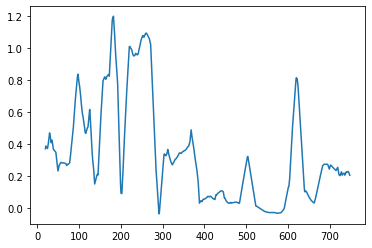

In [14]:
plt.plot(df['FPOGY'].rolling(window=20).mean() )

True

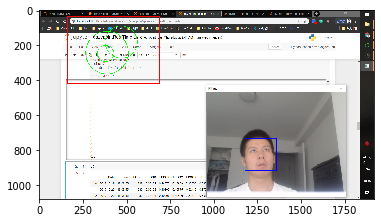

In [15]:
#x = df['FPOGX']
#y = df['FPOGY']
plt.imshow(img)
cv2.imwrite("imagee1.jpg", img)

In [20]:
img[200:300,200:500,0:2].shape

(100, 300, 2)

In [28]:
import cv2
import numpy as np
import os
import pyautogui

output = "video.avi"
img = pyautogui.screenshot()
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
#get info from img
height, width, channels = img.shape
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output, fourcc, 20.0, (width, height))

i=-1
while i<100:
    i+=1
    try:
        img = pyautogui.screenshot()
        img = np.array(img)
        img[200:400,200:400,1] = 1
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(image)
        StopIteration(0.01)
    except KeyboardInterrupt:
        break

out.release()
cv2.destroyAllWindows()

In [22]:
np.array(img)[200:400,200:400,0]=1

smoothing rate 60 per second


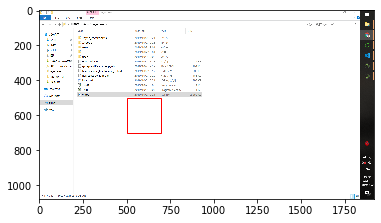

In [27]:
from PIL import ImageGrab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create a Rectangle patch
rate=60
print('smoothing rate',rate,'per second')
x_m  = df['FPOGX'].rolling(window=rate, min_periods=1).mean() 
x_sd = df['FPOGX'].rolling(window=rate, min_periods=1).std()
y_m  = df['FPOGY'].rolling(window=rate, min_periods=1).mean() 
y_sd = df['FPOGY'].rolling(window=rate, min_periods=1).std()

fig, ax = plt.subplots(1)
for i in range(1):
    im = ImageGrab.grab(bbox=None) #ImageGrab.grab(bbox=(10, 10, 510, 510))  # X1,Y1,X2,Y2
    plt.imshow(im)
    
    rect = patches.Rectangle((500,500),200,200,linewidth=1,edgecolor='r',facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    

    #save_path = "C://Users//Cyclops//ai_research//gazepoint//screenCapture//"+ str(i) +".jpg"
    #im.save(save_path)
    
#plt.imshow("C://Users//Cyclops//ai_research//gazepoint//screenCapture/0.jpg")
#def save():
#    os.system("ffmpeg -r 1 -i img%01d.png -vcodec mpeg4 -y movie.mp4")

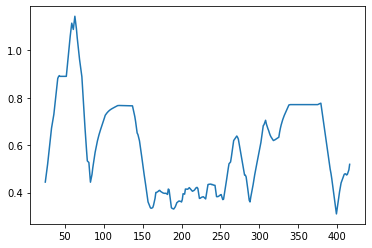

In [24]:
plt.plot(df['FPOGX'].rolling(window=20).mean() )

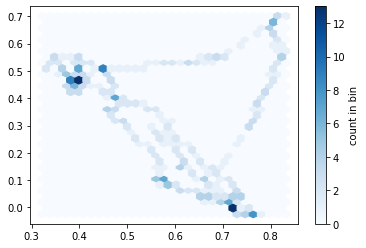

In [25]:
plt.hexbin(x_m, y_m, gridsize=30, cmap='Blues')
cb = plt.colorbar(label='count in bin')

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = np.array(Image.open('C://Users//Cyclops/Downloads/stinkbug.png'), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rate=60
print('smoothing rate',rate,'per second')
x_m  = df['FPOGX'].rolling(window=rate, min_periods=1).mean() 
x_sd = df['FPOGX'].rolling(window=rate, min_periods=1).std()
y_m  = df['FPOGY'].rolling(window=rate, min_periods=1).mean() 
y_sd = df['FPOGY'].rolling(window=rate, min_periods=1).std()
for i in range(0,len(df)):
    w = x_sd[i]*int(WIDTH)
    h = y_sd[i]*int(HEIGHT)
    x = (x_m[i]-2*x_sd[i])*int(WIDTH)
    y = (y_m[i]-2*y_sd[i])*int(HEIGHT)
    print( (x,y),w,h )
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
      
    plt.show()
    time.sleep(0.1)
    

FileNotFoundError: [Errno 2] No such file or directory: 'C://Users//Cyclops/Downloads/stinkbug.png'

In [ ]:
len(df)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(7, 6.5)

ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
patch = plt.Circle((5, -5), 0.75, fc='y')

def init():
    patch.center = (5, 5)
    ax.add_patch(patch)
    return patch,

def animate(i):
    x, y = patch.center
    x = 5 + 3 * np.sin(np.radians(i))
    y = 5 + 3 * np.cos(np.radians(i))
    patch.center = (x, y)
    return patch,

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames=360, 
                               interval=20,
                               blit=True)

plt.show()

In [ ]:
anim.save('animation.mp4', fps=30, 
          extra_args=['-vcodec', 'h264', 
                      '-pix_fmt', 'yuv420p'])

In [ ]:
ffmpeg -i animation.mp4 -r 10 output%05d.png

convert output*.png output.gif

In [ ]:
( np.float(WIDTH), np.float(HEIGHT) )

In [ ]:
import pyscreenshot as ImageGrab

In [ ]:
Welcome to Quandl!
YOUR API KEY IS:
o9ztdUGCXEchosUiasBm
and can be found in your account settings.

Any help you need to get started using our data can be found in the help section.